In [1]:
# Mask-based Curve Detection Model - PyTorch Implementation
# Updated by ChatGPT - May 2025

import os
import json
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# 1. Dataset
# =========================

from PIL import Image

class MaskDataset(Dataset):
    def __init__(self, root_dir, max_lines=3, img_size=(128, 512)):
        """
        root_dir: 数据集根目录，包含'data'和'labels'两个子文件夹
        max_lines: 每个样本最多的标签类别数
        img_size: 图像尺寸，默认(512, 128)
        """
        self.data_dir = os.path.join(root_dir, "data")
        self.labels_dir = os.path.join(root_dir, "labels")
        self.max_lines = max_lines
        self.img_size = img_size

        # 获取所有data图片的文件名（不带扩展名）
        self.sample_names = [
            os.path.splitext(f)[0]
            for f in os.listdir(self.data_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        self.sample_names.sort()

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, idx):
        # 读取data图片
        base_name = self.sample_names[idx]
        data_path = os.path.join(self.data_dir,  base_name + ".png")
        data_img = Image.open(data_path).convert("F").resize(self.img_size, resample=Image.BILINEAR)
        matrix = np.array(data_img, dtype=np.float32)  # [H, W]

        if np.max(matrix) > 0:
            matrix = matrix / np.max(matrix)
        matrix = torch.tensor(matrix).unsqueeze(0)  # [1, H, W]

        # 读取对应的label图片
        masks, types = [], []
        for i in range(1, self.max_lines+1):
            label_name = f"{base_name}_{i:02d}.png"
            label_path = os.path.join(self.labels_dir, label_name)
            if os.path.exists(label_path):
                label_img = Image.open(label_path).convert("L").resize(self.img_size, resample=Image.NEAREST)
                mask_array = np.array(label_img, dtype=np.uint8)  # [H, W]

                if np.max(mask_array) > 0:
                    mask_array = mask_array / np.max(mask_array)
                masks.append(mask_array)
                types.append(i)  # 假设类别就是1,2,3...，如有实际类别映射可自定义
            else:
                # 不足max_lines时补零
                masks.append(np.zeros_like(mask_array, dtype=np.uint8))
                types.append(0)

        masks = np.stack(masks[:self.max_lines])  # [max_lines, H, W]
        types = np.array(types[:self.max_lines])  # [max_lines]

        return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)



# class MaskDataset(Dataset):
#     def __init__(self, root_dir, max_lines=3, img_size=(128, 512)):
#         """
#         root_dir: 数据集根目录，包含'data'和'labels'两个子文件夹
#         max_lines: 每个样本最多的标签类别数
#         img_size: 图像尺寸，默认(512, 128)
#         """
#         self.data_dir = os.path.join(root_dir, "data")
#         self.labels_dir = os.path.join(root_dir, "labels")
#         self.max_lines = max_lines
#         self.img_size = img_size

#         # 获取所有data图片的文件名（不带扩展名）
#         self.sample_names = [
#             os.path.splitext(f)[0]
#             for f in os.listdir(self.data_dir)
#             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
#         ]
#         self.sample_names.sort()

#     def __len__(self):
#         return len(self.sample_names)

#     def __getitem__(self, idx):
#         # 读取data图片
#         base_name = self.sample_names[idx]
#         data_path = os.path.join(self.data_dir,  base_name + ".png")
#         data_img  = Image.open(data_path).convert("F").resize(self.img_size, resample=Image.BILINEAR)
#         matrix    = np.array(data_img, dtype=np.float32)  # [H, W]

#         if np.max(matrix) > 0:
#             matrix = matrix / np.max(matrix)
#         matrix = torch.tensor(matrix).unsqueeze(0)  # [1, H, W]

#         masks, types = [], []       # 读取对应的label图片
#         for i in range(0, self.max_lines):
#             label_name = f"{base_name}_{i:02d}.png"
#             label_path = os.path.join(self.labels_dir, label_name)
#             if os.path.exists(label_path):
#                 label_img = Image.open(label_path).convert("L").resize(self.img_size, resample=Image.NEAREST)
#                 mask_array = np.array(label_img, dtype=np.uint8)  # [H, W]

#                 if np.max(mask_array) > 0:
#                     mask_array = mask_array / np.max(mask_array)
#                 masks.append(mask_array)
#                 types.append(i)  # 假设类别就是1,2,3...，如有实际类别映射可自定义
#             else:
#                 # 不足max_lines时补零
#                 masks.append(np.zeros_like(mask_array, dtype=np.uint8))
#                 types.append(-1)

#         masks = np.stack(masks[:self.max_lines])  # [max_lines, H, W]
#         types = np.array(types[:self.max_lines])  # [max_lines]

#         return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)

In [2]:
class MaskDataset(Dataset):
    def __init__(self, root_dir, max_lines=3, img_size=(128, 512)):
        self.data_dir = os.path.join(root_dir, "data")
        self.labels_dir = os.path.join(root_dir, "labels")
        self.max_lines = max_lines
        self.img_size = img_size

        self.sample_names = [
            os.path.splitext(f)[0]
            for f in os.listdir(self.data_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        self.sample_names.sort()

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, idx):
        base_name = self.sample_names[idx]
        data_path = os.path.join(self.data_dir, base_name + ".png")
        data_img = Image.open(data_path).convert("F").resize(self.img_size, resample=Image.BILINEAR)
        matrix = np.array(data_img, dtype=np.float32)
        
        if np.max(matrix) > 0:
            matrix = matrix / np.max(matrix)
        matrix = torch.tensor(matrix).unsqueeze(0)

        masks, types, valid = [], [], []
        for i in range(self.max_lines):
            label_name = f"{base_name}_{i:02d}.png"
            label_path = os.path.join(self.labels_dir, label_name)
            if os.path.exists(label_path):
                label_img = Image.open(label_path).convert("L").resize(self.img_size, resample=Image.NEAREST)
                mask_array = np.array(label_img, dtype=np.uint8)
                if np.max(mask_array) > 0:
                    mask_array = mask_array / np.max(mask_array)
                masks.append(mask_array)
                types.append(i)
                valid.append(1)
            else:
                masks.append(np.zeros(self.img_size, dtype=np.uint8))
                types.append(0)  # 填充值，训练时会被忽略
                valid.append(0)

        return {
            'image': matrix,
            'masks': torch.tensor(np.stack(masks), dtype=torch.float32),
            'types': torch.tensor(types, dtype=torch.long),
            'valid': torch.tensor(valid, dtype=torch.bool)
        }

In [3]:
class MaskTypeTransformer(nn.Module):
    def __init__(self, in_channels=1, max_lines=3, embed_dim=256):
        super().__init__()

        # 设置最大曲线数，同时用作类别数量
        # self.num_types = num_types = self.max_lines = max_lines
        num_types = max_lines + 1
        self.num_types = num_types
        self.max_lines= max_lines
        # CNN 特征提取器：提取空间特征
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  # 输入图像从 [B, 1, 128, 128] -> [B, 32, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),  # 下采样 -> [B, 32, 64, 64]

            nn.Conv2d(32, 64, 3, padding=1),  # 提升通道数 -> [B, 64, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),  # 下采样 -> [B, 64, 32, 32]

            nn.Conv2d(64, embed_dim, 3, padding=1),  # 最终通道数提升到 embed_dim -> [B, 256, 32, 32]
            nn.ReLU()
        )

        # Transformer 编码器：处理空间特征中的长距离依赖关系
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  # 嵌入维度，即每个 token 的维度
            nhead=8,            # 多头注意力中头的数量
            batch_first=True    # 使用 batch 在第一维（更自然）
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)  # 堆叠两个编码层

        # mask 头：对 transformer 编码后的特征进行上采样，生成每条曲线的掩膜
        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),         # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, max_lines, kernel_size=2, stride=2),   # 128x128 -> 256x256
            nn.ReLU(),
            nn.Conv2d(max_lines, max_lines, kernel_size=3, padding=1),    # 保持通道数，细化特征
            nn.Upsample(size=(512, 128), mode="bilinear", align_corners=False)  # 插值上采样到统一尺寸
        )

        # type 头：对整体特征进行池化+线性变换，输出每条曲线的类别分布
        self.type_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 对每个通道做全局平均池化，得到 [B, C, 1, 1]
            nn.Flatten(),             # 展平 -> [B, C]
            nn.Linear(embed_dim, max_lines * num_types)  # 输出维度为每条曲线的类别概率分布
        )

    def forward(self, x):
        # CNN 提取特征
        feats = self.backbone(x)  # 输出 [B, 256, 32, 32]

        # 获取形状信息
        B, C, H, W = feats.shape

        # 将特征展平为序列形式，供 Transformer 使用
        flattened = feats.view(B, C, -1).permute(2, 0, 1)  # [B, C, H*W] -> [H*W, B, C]

        # 使用 Transformer 编码空间特征
        encoded = self.transformer(flattened)  # [H*W, B, C]

        # 再将输出转回图像格式 [B, C, H, W]
        encoded = encoded.permute(1, 2, 0).view(B, C, H, W)

        # 利用上采样模块生成多通道的 mask，代表每条曲线的位置
        masks = self.mask_head(encoded)  # [B, max_lines, 512, 128]

        # 利用分类头预测每条曲线的类别
        types = self.type_head(encoded)  # [B, max_lines * num_types]
        types = types.view(B, self.max_lines, self.num_types)  # 调整形状为 [B, max_lines, num_types]

        return masks, types

In [ ]:
model = MaskTypeTransformer(max_lines=5).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_path = 'checkpoints/png3/model_00080.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))


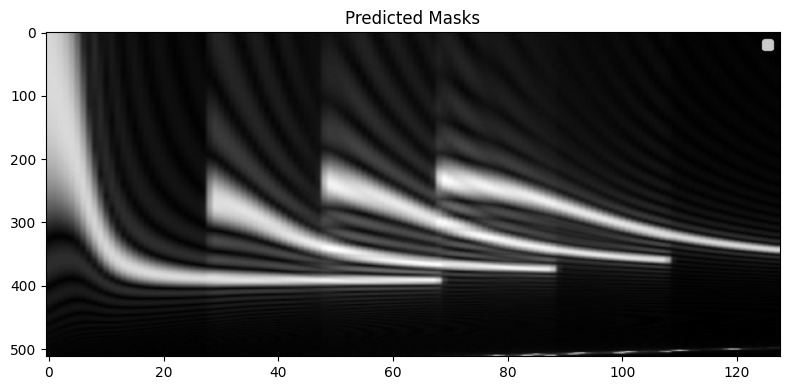

In [17]:
# data_dir = "/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/dataset_png/test"
data_dir = "/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/dataset_png/train"
dataset = MaskDataset(data_dir, max_lines=5)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 可视化最后一个 batch 的第一个样本
x, y_masks, y_types = next(iter(loader))

j = 2
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

matrix = x[j]
y_type = y_types[j]
pred_mask = pred_masks[j]
pred_type = pred_types[j]
threshold = 0.15

ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
pred_mask = torch.sigmoid(pred_mask)
pred_type = pred_type.argmax(dim=1)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

legend_elements = []

styles = ['x', '+', 'x', '+', 'x', '+']
for i in range(pred_mask.shape[0]):
    mask = pred_mask[i] > threshold
    if mask.sum() > 0:
        coords = torch.nonzero(mask, as_tuple=False).cpu().numpy()
        if coords.size > 0:
            ax.plot(coords[:, 1], coords[:, 0], 
                    styles[pred_type[i]], 
                    color=f"C{i}", 
                    label=f"type{pred_type[i]}")
            legend_elements.append(Line2D([0], [0], color=f"C{i}", marker=styles[pred_type[i]], linestyle='None', label=f"type{pred_type[i]}"))

ax.set_title("Predicted Masks")
ax.legend(handles=legend_elements)
fig.tight_layout()
plt.show()

In [18]:
print(pred_type, y_type)

tensor([1, 2, 3, 4, 5], device='cuda:0') tensor([1, 2, 3, 4, 0])


In [11]:
x.shape, y_masks.shape, y_types.shape, pred_masks.shape, pred_types.shape

(torch.Size([16, 1, 512, 128]),
 torch.Size([16, 5, 512, 128]),
 torch.Size([16, 5]),
 torch.Size([16, 5, 512, 128]),
 torch.Size([16, 5, 6]))

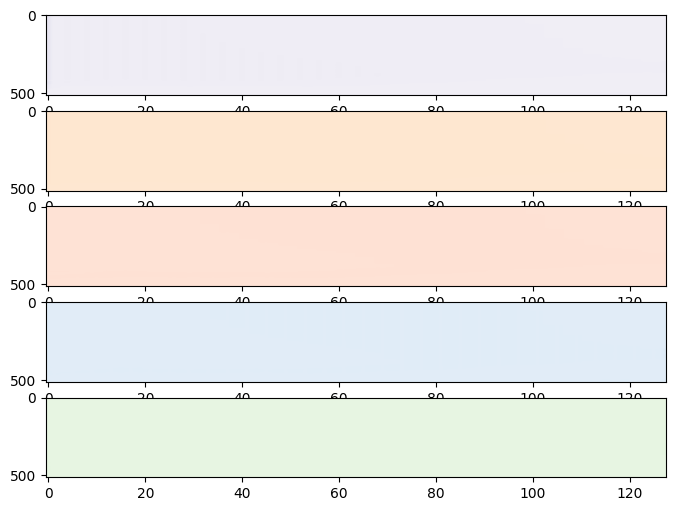

In [ ]:
num = int(pred_type.max().cpu().numpy())

colors = ['Purples', 'Oranges', 'Reds', 'Blues', 'Greens']

fig, axes = plt.subplots(num, 1, figsize=(8, 6))
for i in range(num):
    axes[i].imshow(pred_mask[i].squeeze().cpu(), cmap=colors[i], aspect='auto', vmin=-0.1, vmax=0.8)



In [9]:
y_masks[i][0].shape

torch.Size([512, 128])

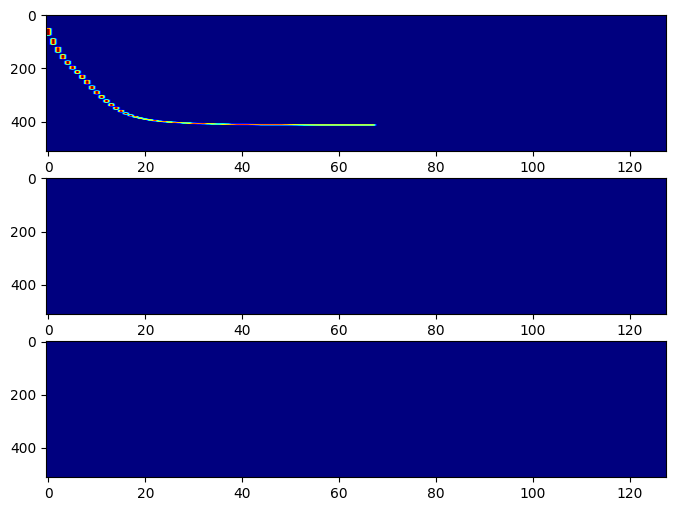

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].imshow(y_masks[i][0].squeeze().cpu(), cmap='jet', aspect='auto')
axes[1].imshow(y_masks[i][1].squeeze().cpu(), cmap='jet', aspect='auto')
axes[2].imshow(y_masks[i][2].squeeze().cpu(), cmap='jet', aspect='auto')